# Cohort Analysis

### Data analysis workflow

Selene Reyes

## Table of Content

1. [DATA](#data)<br>
2. [EXPLORATORY DATA ANALYSIS](#eda)<br>
3. [COHORT ANALYSIS](#cohort)<br>
4. [CUSTOMER LIFETIME VALUE](#clv)<br>

### Importing libraries

In [23]:
from urllib.request import urlretrieve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import datetime, date, timedelta
import os

<a id='data'></a>
# 1. Data

This data set contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based online retail business. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

 __Data source:__ <br>
UCI Machine Learning Repository   __[Link to dataset](https://archive.ics.uci.edu/ml/datasets/Online%20Retail)__

<a id='eda'></a>
# 2. EDA

In [2]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

In [24]:
def get_data(filename='online_retail.xlsx', url=URL):
    if not os.path.exists(filename):
        urlretrieve(url, filename)
    xls = pd.ExcelFile(filename)
    data = pd.read_excel(xls, parse_dates = ['InvoiceDate'])
    return data

In [25]:
online = get_data()

In [26]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


<a id='cohort'></a>
# 3. Cohort Analysis
Cohort: group of people who have become a customer around the same time

### It groups customers into different behavioral segments. It allows to:

> ### -  Evolution over time (long term relationship) 
> ### -  Compare cohort groups over time (and product lifetime) <br>


![Cohort](Cohort.png)<br><br>


## 3.1 Time cohort (monthly)
Shows the customers’ behavior depending on the time they start using the product or services (monthly, quarterly)

We will create monthly cohorts, based on the month each customer has made their first transaction.<br>
### ==> Adding: 'InvoiceMonth' and 'CohortMonth' columns

In [6]:
def get_month(x): 
    """
    Returns parsed date (YYYY-MM-01)

    Parameters
    ----------
    x: array of dates
    """
    return dt.datetime(x.year, x.month, 1) 

In [7]:
# InvoiceDay column
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month) 

# Grouping by CustomerID and selecting the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceMonth'] 

# Assigning a minimum InvoiceDay value to the dataset
online['CohortMonth'] = grouping.transform('min')

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


### ==> Time offset: number of months between any trasaction and the first trasactions of each customer.

In [8]:
def get_date_int(df, column):
    """Extract year, month, and day integer values
        
    Args:
        arg_1 (df):
        arg_2 (str): column name with datetime values
    
    Returns:
        int(year), int(months), int(days)
    """
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    
    return year, month, day

In [9]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceMonth')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortMonth')

## $$ CohortIndex = InvoiceMonth - CohortMonth $$

In [10]:
# Difference in years between the moment of the invoice and the moment the cohort was created 
years_diff =  invoice_year - cohort_year

# Calculate difference in months between the moment of the invoice and the moment the cohort was created 
months_diff = invoice_month - cohort_month


# Extract the difference in months from all previous values and
# Assign the monthly time offset to each transaction
online['CohortIndex'] = years_diff * 12 + months_diff + 1
online.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0


## Metrics

### Retention
## $$ Retention =\frac{Active Customers}{Total Customers} $$
  <t>How many customers originally in each cohort have return in the subsequent month?

Steps:<br>
a) Select the first column (total number of customers in the cohort)<br>
b) Calculate the ratio of how many of these customers were active in the following months

In [11]:
grouping = online.groupby(['CohortMonth','CohortIndex'])

# Number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

cohort_data['CohortMonth'] = cohort_data.CohortMonth.dt.date

cohort_counts = cohort_data.pivot(index='CohortMonth', 
                                  columns='CohortIndex', 
                                  values='CustomerID')

# First column stored as cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0).mul(100)

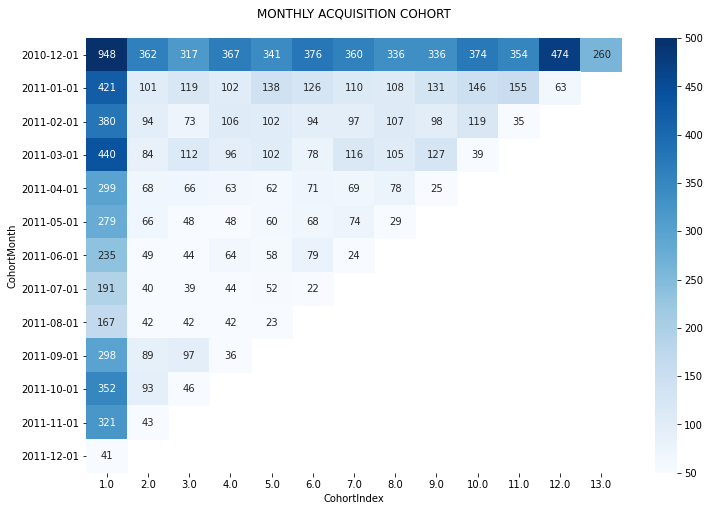

In [12]:
plt.figure(figsize=(12, 8))
plt.title('MONTHLY ACQUISITION COHORT\n')
sns.heatmap(data=cohort_counts, annot=True, cmap='Blues', fmt='.0f', vmin=50, vmax=500);
print()

In December of 2010 the company had the highest number of new customers (948 new customers). Acquisition has declined, reaching the lowest numbers in August of 2011 (167 new customers). From September 2011 company was able to increase acquisition. It would be worth investigating if there was a new marketing campaign or strategy change.

The heatmap below shows the monthly retention rate (in %), i.e., percentage of customers originally in each cohort that have made a purchase the subsequent month.

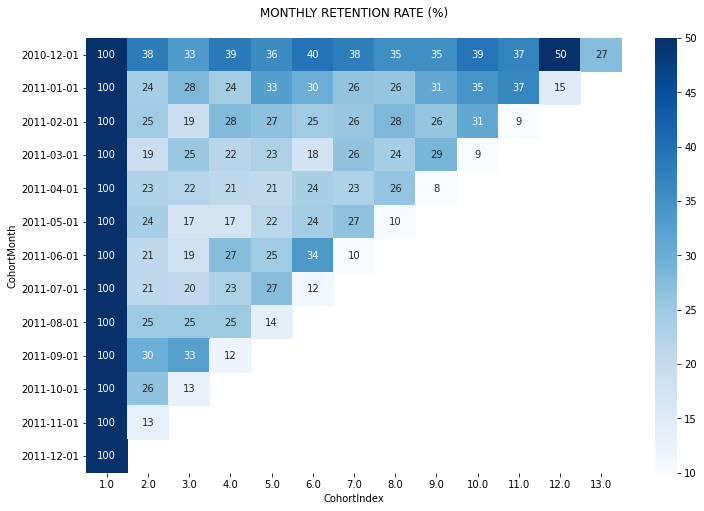

In [13]:
plt.figure(figsize=(12, 8))
plt.title('MONTHLY RETENTION RATE (%)\n')
sns.heatmap(data=retention, annot=True, cmap='Blues', fmt='.0f', vmin=10, vmax=50);
print()

The retention rate in majority of cohorts is less than 30%, having the lowest rates of 9% for the cohorts  of February and March in the 11th and 10th month since they made their first purchase.

### Churn
## $$ Churn = 1 - Retention $$

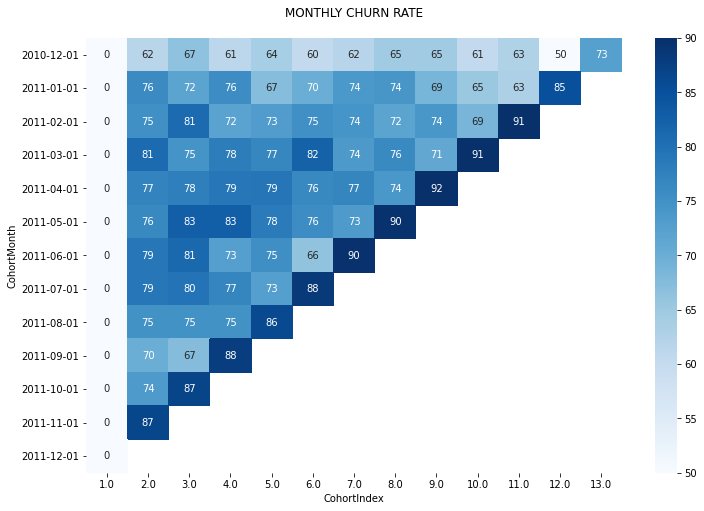

In [14]:
# Churn Rate
churn = 100 - retention

plt.figure(figsize=(12, 8))
plt.title('MONTHLY CHURN RATE\n')
sns.heatmap(data=churn, annot=True, cmap='Blues', fmt='.0f', vmin=50, vmax=90);

The retention rate in majority of cohorts is less than 30%. It is important to keep in mind that the month of December has data for only 9 days. Not considering the month of December, the lowest retention rate was for the cohort of May (17% in the 3th and 4th cohort index), and the highest retention rate was for the cohort of December 2010 (50% of customers making a purchase in the 12th cohort index).

## 3.2 Size cohorts

Amount of spending over a period of time, or the product type the customer spend more.

### Average Order Value (AOV)
Are there any differences in shopping patterns across time and across cohorts?

In [15]:
# Calculate total amount spent per invoice
online['Amount'] = online.Quantity * online.UnitPrice
online.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,20.34


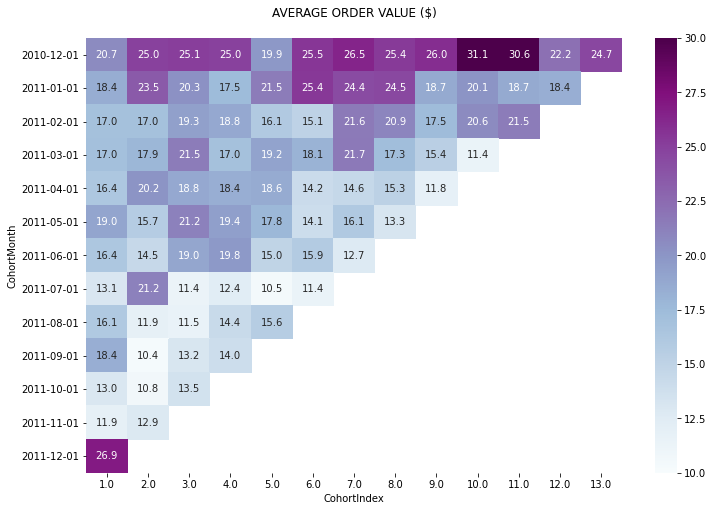

In [16]:
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Average amount spent by monthly cohort
cohort_data = grouping['Amount'].mean().reset_index()

cohort_data['CohortMonth'] = cohort_data.CohortMonth.dt.date

average_spent = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Amount')

plt.figure(figsize=(12, 8))
plt.title('AVERAGE ORDER VALUE ($)\n')
sns.heatmap(data=average_spent, annot=True, cmap='BuPu', fmt='.1f', vmin=10, vmax=30);

### Average quantity

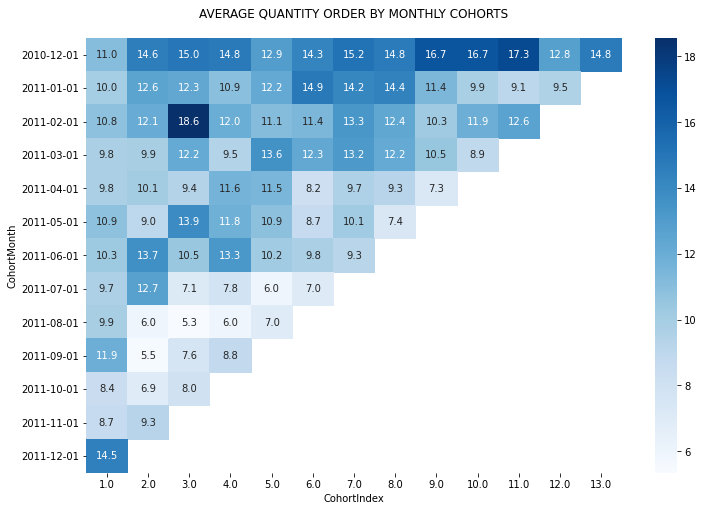

In [17]:
# Average quantity by monthly cohort
cohort_data = grouping['Quantity'].mean().reset_index()

cohort_data['CohortMonth'] = cohort_data.CohortMonth.dt.date
 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')

plt.figure(figsize=(12, 8))
plt.title('AVERAGE QUANTITY ORDER BY MONTHLY COHORTS\n')
sns.heatmap(data=average_quantity, annot=True, cmap='Blues', fmt='.1f');

### Average Unit Price

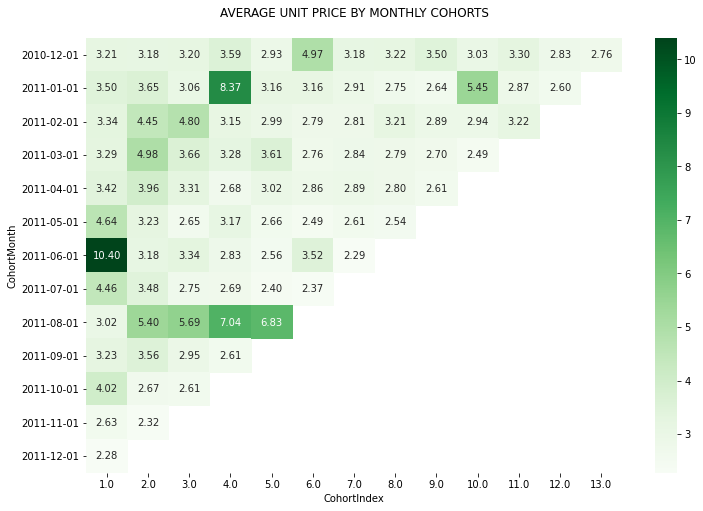

In [18]:
# Average of the unit price 
cohort_data = grouping['UnitPrice'].mean().reset_index()

cohort_data['CohortMonth'] = cohort_data.CohortMonth.dt.date

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')

plt.figure(figsize=(12, 8))
plt.title('AVERAGE UNIT PRICE BY MONTHLY COHORTS\n')
sns.heatmap(data=average_price, annot=True, cmap='Greens', fmt='.2f');

<a id='clv'></a>
# 4. Customer Lifetime Value

### GOAL: 
* Measure customer value in revenue or profit
* Benchmark customers and asses the max investment into customer acquisition (CAC)<br><br>

![CLV](CLV.png)

## 4.1 Traditional CLV 

### This approach accounts for customer loyalty by using retention and churn rates<br>
### $$ \text Taditional CLV = (Avg Revenue * Profit Margin) * \frac {Retention Rate}{Churn Rate}$$



In [19]:
# Mean retention rate 
retention_rate = retention.iloc[:,1:].mean().mean()

# Mean churn rate
churn_rate = churn.iloc[:,1:].mean().mean()

print(f'Average retention rate: {retention_rate:.1f}%\nAverage churn rate: {churn_rate:.1f}%')

Average retention rate: 26.2%
Average churn rate: 73.8%


In [20]:
# Monthly spend per customer
monthly_revenue = online.groupby(['CustomerID','InvoiceMonth'])['Amount'].sum().mean()

# Calculate traditional CLV 
clv_traditional = monthly_revenue * (retention_rate / churn_rate)

print(f'Average traditional CLV is $ {clv_traditional:.0f} at {retention_rate:.1f}% retention rate')

Average traditional CLV is $ 215 at 26.2% retention rate


<img src="https://wordstream-files-prod.s3.amazonaws.com/s3fs-public/styles/simple_image/public/images/media/images/CAC-CLV-ratio.png?7KAzaGeYoBoCC._QEsGtAiqP7bYv1jk7&itok=t9BE8Q65" width="600" />

On average, the customer lifetime value is $ 215. The company can now better estimate the customer acquisition cost (CAC). It would be convenient to perform a customer segmentation analysis to better asses the max investment into customer acquisition. This analysis was performed in the following Jupyter notebook.